In [104]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso

# Generate synthetic data for p > n situation
np.random.seed(42)
n, p = 3, 10  # n observations, p predictors

X = np.random.randn(n, p)
true_beta = np.zeros(p)
true_beta[:10] = np.random.randn(10)  # Only first 10 predictors have non-zero coefficients
y = X @ true_beta + np.random.randn(n) * 0.1  # Add a bit of noise

lasso = Lasso(alpha=4e-5, tol = 1e-16, max_iter = 100000)

lasso.fit(X, y)

# Get the coefficients and count the number of non-zero coefficients
lasso_coef = lasso.coef_
non_zero_coef_count = np.sum(lasso_coef != 0)

# Prepare the results
results = pd.DataFrame({
    'Predictor': np.arange(p),
    'Coefficient': lasso_coef
})

print(f'Number of non-zero coefficients: {non_zero_coef_count}')
print(results)


Number of non-zero coefficients: 2
   Predictor  Coefficient
0          0    -0.547627
1          1    -0.000000
2          2    -0.000000
3          3    -0.799521
4          4    -0.000000
5          5    -0.000000
6          6    -0.000000
7          7    -0.000000
8          8    -0.000000
9          9    -0.000000


In [105]:
np.abs(np.sum(lasso_coef))

1.347148847746439

In [106]:
np.linalg.norm(y  - lasso.predict(X))

9.453301729601485e-05

In [108]:
y / lasso.predict(X)

array([1.00001145, 1.00009283, 1.00007718])

In [109]:
X

array([[ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
        -0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004],
       [-0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783,
        -0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ],
       [ 1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272,
         0.11092259, -1.15099358,  0.37569802, -0.60063869, -0.29169375]])

In [191]:
c = np.ones(2 * p)  # Objective function: minimize the sum of the z variables
# Construct the constraint matrix for the equality y = X @ beta
A_eq = np.hstack([X, -X])
b_eq = y
# Construct the constraint matrices for the inequality z >= beta and z >= -beta
A_ineq = np.vstack([np.hstack([np.eye(p), -np.eye(p)]), np.hstack([-np.eye(p), -np.eye(p)])])
b_ineq = np.zeros(2 * p)
# Solve the linear programming problem
result = linprog(c, A_ub=A_ineq, b_ub=b_ineq, A_eq=A_eq, b_eq=b_eq, method='interior-point')
# Extract the optimized beta values
beta_optimized = result.x[:p] - result.x[p:]
print("True beta:", true_beta)
print("Optimized beta:", beta_optimized)

True beta: [-0.60170661  1.85227818 -0.01349722 -1.05771093  0.82254491 -1.22084365
  0.2088636  -1.95967012 -1.32818605  0.19686124]
Optimized beta: [-7.72679528e-01 -5.28006418e-13 -1.24556229e-11  2.94071652e-13
 -7.59931640e-14 -3.82734109e-13 -7.89725518e-01 -1.06892844e+00
  1.58252253e-15 -1.66774025e-12]


In [193]:
result.x

array([8.61904990e-13, 1.31002821e-12, 6.13182824e-13, 8.12903615e-13,
       1.47069171e-12, 1.37312080e-12, 6.06557940e-13, 1.92861604e-13,
       1.53305084e-12, 9.03686712e-13, 7.72679528e-01, 1.83803463e-12,
       1.30688057e-11, 5.18831963e-13, 1.54668487e-12, 1.75585491e-12,
       7.89725518e-01, 1.06892844e+00, 1.53146832e-12, 2.57142697e-12])

In [192]:
X @ beta_optimized

array([-2.45127833,  0.82202403, -0.6251021 ])

In [187]:
import math
threshold = 1e-10
beta_optimized[np.abs(beta_optimized) < threshold] = 0
beta_optimized

array([-0.77267953,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.78972552, -1.06892844,  0.        ,  0.        ])

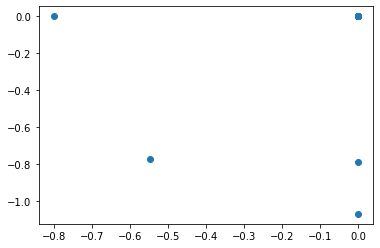

In [188]:
plt.scatter(lasso_coef, beta_optimized)

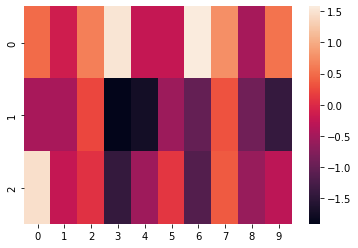

In [189]:
sns.heatmap(X)

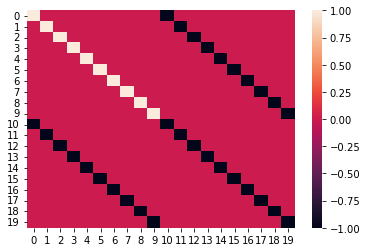

In [190]:
sns.heatmap(A_ineq)

 \begin{align}
 \min_x \ & c^T x \\
        \mbox{such that} \ & A_{ub} x \leq b_{ub},\\
        & A_{eq} x = b_{eq},\\
        & l \leq x \leq u ,
 \end{align}
 
  \begin{align}
 \min_x \ & \sum_i \beta_i \\
        \mbox{such that} \ & \beta_i^+ - \beta_i^- \leq 0,\\
        & [x,-x] \beta = y
 \end{align}

In [154]:
import numpy as np
from scipy.optimize import linprog

def get_optimal_x_for_bp(A, y):
    x_dim, y_dim = A.shape[1], y.shape[0]
    eye = np.eye(x_dim)

    obj = np.concatenate([np.zeros(x_dim), np.ones(x_dim)])

    lhs_ineq = np.concatenate([np.concatenate([eye, eye], axis=1), np.concatenate([eye, -eye], axis=1)], axis=0)
    rhs_ineq = np.zeros(2 * x_dim)

    lhs_eq = np.concatenate([A, np.zeros((y_dim, x_dim))], axis=1)
    rhs_eq = y

    bnd = [*((None, None) for _ in range(x_dim)), *((0, None) for _ in range(x_dim))]

    res = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq, A_eq=lhs_eq, b_eq=rhs_eq, bounds=bnd, method="revised simplex",options = {'tol': 1e-16})
    return res.x[:x_dim]

In [155]:
betas = get_optimal_x_for_bp(X,y)

In [156]:
betas

array([-0.55050732,  0.        ,  0.        , -0.57498042,  0.        ,
        0.        ,  0.        , -1.69671916,  0.        ,  0.        ])

In [148]:
np.abs(np.sum(betas))

2.8222068968442464

In [149]:
np.linalg.norm(y - X @ betas )

1.5700924586837752e-16

In [150]:
betas

array([-0.55050732,  0.        ,  0.        , -0.57498042,  0.        ,
        0.        ,  0.        , -1.69671916,  0.        ,  0.        ])

In [64]:
import cvxpy as cp
# import numpy as np


# # Define the optimization variable
# x = cp.Variable(X.shape[1])

# # Define the objective function
# objective = cp.Minimize(cp.norm(x, 1))

# # Define the constraints
# constraints = [X @ x == b]

# # Form and solve the problem
# problem = cp.Problem(objective, constraints)
# result = problem.solve()

# # The optimized x
# x_optimized = x.value

# print("Optimized x:", x_optimized)


ModuleNotFoundError: No module named 'cvxpy'

In [55]:
np.linalg.norm(y - X@ beta_optimized )

3.4155971494245918e-12

In [56]:
np.sum(np.abs(beta_optimized))

2.631333490109379

In [58]:
np.eye(p)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
#plot penalty versus error (only shrinkage since small d)

In [4]:
# show singular value error versus sparsity parametrized by lambda
import montlake
help(montlake)

Help on package montlake:

NAME
    montlake

PACKAGE CONTENTS
    None
    _nbdev
    atomgeom (package)
    core
    exec (package)
    geometry (package)
    gradients (package)
    mflasso (package)
    optimization (package)
    plotting (package)
    simulations (package)
    statistics (package)
    tslasso (package)
    utils (package)
    vendor (package)

VERSION
    0.0.1

FILE
    /Users/samsonkoelle/miniconda3/envs/montlake_xxx/lib/python3.6/site-packages/montlake/__init__.py




In [6]:
# AUTOGENERATED! DO NOT EDIT! File to edit: nbs/optimization.gradientgrouplasso.ipynb (unless otherwise specified).

__all__ = ['GradientGroupLasso', 'get_sr_lambda_parallel', 'batch_stream']

# Cell
#loosely inspired by the pyglmnet package
from einops import rearrange
#import autograd.numpy as np
import numpy as np

class GradientGroupLasso:

    def __init__(self, dg_M, df_M, reg_l1s, reg_l2, max_iter,learning_rate, tol, beta0_npm= None):

        n = dg_M.shape[0]
        d= dg_M.shape[1]
        m = df_M.shape[2]
        p = dg_M.shape[2]
        dummy_beta = np.ones((n,p,m))

        self.dg_M = dg_M
        self.df_M = df_M
        self.reg_l1s = reg_l1s
        self.reg_l2 = reg_l2
        self.beta0_npm = beta0_npm
        self.n = n
        self.p = p
        self.m = m
        self.d = d
        self.dummy_beta = dummy_beta
        #self.group = np.asarray(group)
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.tol = tol
        self.Tau = None
        self.alpha = 1.
        self.lossresults = {}
        self.dls = {}
        self.l2loss = {}
        self.penalty = {}

    def _prox(self,beta_npm, thresh):
        """Proximal operator."""

        p = self.p
        result = np.zeros(beta_npm.shape)
        result = np.asarray(result, dtype = float)
        for j in range(p):
            if np.linalg.norm(beta_npm[:,j,:]) > 0.:
                potentialoutput = beta_npm[:,j,:] - (thresh / np.linalg.norm(beta_npm[:,j,:])) * beta_npm[:,j,:]
                posind = np.asarray(np.where(beta_npm[:,j,:] > 0.))
                negind = np.asarray(np.where(beta_npm[:,j,:] < 0.))
                po = beta_npm[:,j,:].copy()
                po[posind[0],posind[1]] = np.asarray(np.clip(potentialoutput[posind[0],posind[1]],a_min = 0., a_max = 1e15), dtype = float)
                po[negind[0],negind[1]] = np.asarray(np.clip(potentialoutput[negind[0],negind[1]],a_min = -1e15, a_max = 0.), dtype = float)
                result[:,j,:] = po
        return result

    def _grad_L2loss(self, beta_npm):

        df_M = self.df_M
        dg_M = self.dg_M
        reg_l2 = self.reg_l2
        dummy_beta = self.dummy_beta

        df_M_hat = np.einsum('ndp,npm->ndm',dg_M, beta_npm)
        error = df_M_hat - df_M
        grad_beta = np.einsum('ndm,ndp->npm',error,dg_M) #+ reg_l2 * np.ones()
        #if
        return grad_beta

    def _L1penalty(self, beta_npm):

        p = self.p
        m = self.m
        n = self.n
        beta_mn_p = rearrange(beta_npm, 'n p m -> (m n) p')#np.reshape(beta_mnp, ((m*n,p)))
        L1penalty = np.linalg.norm(beta_mn_p, axis = 0).sum()

        return L1penalty

    def _loss(self,beta_npm, reg_lambda):
        """Define the objective function for elastic net."""
        L = self._logL(beta_npm)
        P = self._L1penalty(beta_npm)
        J = -L + reg_lambda * P
        return J

    def _logL(self,beta_npm):

        df_M = self.df_M
        dg_M = self.dg_M

        df_M_hat = np.einsum('ndp,npm -> ndm',dg_M, beta_npm)
        logL = -0.5 * np.linalg.norm((df_M - df_M_hat))**2
        return(logL)

    def _L2loss(self,beta_npm):
        output = -self._logL(beta_npm)
        return(output)

    def fhatlambda(self,learning_rate,beta_npm_new,beta_npm_old):

        #print('lr',learning_rate)
        output = self._L2loss(beta_npm_old) + np.einsum('npm,npm', self._grad_L2loss(beta_npm_old),(beta_npm_new-beta_npm_old)) + (1/(2*learning_rate)) * np.linalg.norm(beta_npm_new-beta_npm_old)**2

        return(output)

    def _btalgorithm(self,beta_npm ,learning_rate,b,maxiter_bt,rl):

        grad_beta = self._grad_L2loss(beta_npm = beta_npm)
        for i in range(maxiter_bt):
            beta_npm_postgrad = beta_npm - learning_rate * grad_beta
            beta_npm_postgrad_postprox = self._prox(beta_npm_postgrad, learning_rate * rl)
            fz = self._L2loss(beta_npm_postgrad_postprox)
            #fhatz = self.fhatlambda(lam,beta_npm_postgrad_postprox, beta_npm_postgrad)
            fhatz = self.fhatlambda(learning_rate,beta_npm_postgrad_postprox, beta_npm)
            if fz <= fhatz:
                #print(i)
                break
            learning_rate = b*learning_rate

        return(beta_npm_postgrad_postprox,learning_rate)

    
    def _cdfast(self, X, y, ActiveSet, beta, rl, fit_intercept=True):
 
        n, d, p = X.shape
        #reg_scale = rl * (1 - self.alpha) # the fuck is this?
#         z = _z(beta[0], beta[1:], X, fit_intercept)
        z = np.einsum('n d p, n p m -> n d m', X, beta) # n will typically be 1 for the case I'm working on rn
        for k in range( p):
            for j in range(d):
                # Only update parameters in active set
                if ActiveSet[k,j] != 0:

                    xk = X[:, :,k ] # need to update one coordinate at a time w.r.t both p and m

                    # Calculate grad and hess of log likelihood term
                    gk, hk = _gradhess_logloss_1d(xk, y[:,:,j], z, self.eta,
                                                  self.theta, fit_intercept)

                    # Add grad and hess of regularization term
                    if self.Tau is None:
                        gk_reg, hk_reg = beta[k], 1.0
                    else:
                        InvCov = np.dot(self.Tau.T, self.Tau)
                        gk_reg = np.sum(InvCov[k, :] * beta)
                        hk_reg = InvCov[k, k]
                    gk += reg_scale * gk_reg
                    hk += reg_scale * hk_reg

                    # Ensure that update does not blow up if Hessian is small
                    update = 1. / hk * gk if hk > 1. else self.learning_rate * gk

                    # Update parameters, z
                    beta[:,j,k], z = beta[:,j,k] - update, z - update * xk
        return beta

    def fit(self, beta0_npm = None):

        reg_l1s = self.reg_l1s
        n = self.n
        m = self.m
        p = self.p

        dg_M = self.dg_M
        df_M = self.df_M

        tol = self.tol
        np.random.RandomState(0)

        if beta0_npm is None:
            beta_npm_hat = 1 / (n*m*p) * np.random.normal(0.0, 1.0, [n, p,m])
            #1 / (n_features) * np.random.normal(0.0, 1.0, [n_features, n_classes])
        else:
            beta_npm_hat = beta0_npm

        fit_params = list()
        for l, lambda_ in enumerate(reg_l1s):
            fit_params.append({'beta': beta_npm_hat})
            if l == 0:
                fit_params[-1]['beta'] = beta_npm_hat
            else:
                fit_params[-1]['beta'] = fit_params[-2]['beta']

            alpha = 1.
            beta_npm_hat = fit_params[-1]['beta']
            #g = np.zeros([n_features, n_classes])
            L, DL ,L2,PEN = list(), list() , list(), list()
            learning_rate = self.learning_rate
            beta_npm_hat_1 = beta_npm_hat.copy()
            beta_npm_hat_2 = beta_npm_hat.copy()
            for t in range(0, self.max_iter):
                #print(t,l,rl)
                #print(t)
                L.append(self._loss(beta_npm_hat, lambda_))
                L2.append(self._L2loss(beta_npm_hat))
                PEN.append(self._L1penalty(beta_npm_hat))
                self._cdfast(X, y, ActiveSet, beta, lambda_,
                             self.fit_intercept)
                beta = self._prox(beta, self.learning_rate * reg_lambda)
                ActiveSet[beta == 0] = 0
                
                # Convergence by relative parameter change tolerance
                norm_update = np.linalg.norm(beta - beta_old)
                norm_update /= np.linalg.norm(beta)
                self._convergence.append(norm_update)
                if t > 1 and self._convergence[-1] < tol:
                    msg = ('\tParameter update tolerance. ' +
                           'Converged in {0:d} iterations'.format(t))
                    _tqdm_log(msg)
                    break

                # Compute and save loss if callbacks are requested
                if callable(self.callback):
                    self.callback(beta)
#                 w = (t / (t+ 3))
#                 beta_npm_hat_momentumguess = beta_npm_hat + w*(beta_npm_hat_1 - beta_npm_hat_2)

#                 beta_npm_hat , learning_rate = self._btalgorithm(beta_npm_hat_momentumguess,learning_rate,.5,1000, rl)
#                 #print(beta_npm_hat_momentumguess.max(), beta_npm_hat.max(),self._L2loss(beta_npm_hat), learning_rate)
#                 beta_npm_hat_2 = beta_npm_hat_1.copy()
#                 beta_npm_hat_1 = beta_npm_hat.copy()

#                 if t > 1:
#                     DL.append(L[-1] - L[-2])
#                     if np.abs(DL[-1] / L[-1]) < tol:
#                         print('converged', rl)
#                         msg = ('\tConverged. Loss function:'
#                                ' {0:.2f}').format(L[-1])
#                         msg = ('\tdL/L: {0:.6f}\n'.format(DL[-1] / L[-1]))
#                         break

            fit_params[-1]['beta'] = beta_npm_hat
            self.lossresults[lambda_] = L
            self.l2loss[lambda_] = L2
            self.penalty[lambda_] = PEN
            self.dls[lambda_] = DL

        self.fit_ = fit_params
        #self.ynull_ = np.mean(y)

        return self

from einops import rearrange
import numpy as np

In [8]:


def _gradhess_logloss_1d(xk, y, z, eta, theta, fit_intercept=True):
    """
    Compute gradient (1st derivative)
    and Hessian (2nd derivative)
    of log likelihood for a single coordinate.

    Parameters
    ----------
    xk: float
        (n_samples,)
    y: float
        (n_samples,)
    z: float
        (n_samples,)

    Returns
    -------
    gk: gradient, float:
        (n_features + 1,)
    hk: float:
        (n_features + 1,)
    """
    n_samples = xk.shape[0]


    gk = np.sum((z - y) * xk)
    hk = np.sum(xk * xk)

    return 1. / n_samples * gk, 1. / n_samples * hk



In [9]:
self._cdfast(X, y, ActiveSet, beta, reg_lambda,
             self.fit_intercept)

NameError: name 'self' is not defined

In [ ]:
# what we call group lasso is in fact multitask lasso

In [10]:
import numpy as np

rng = np.random.RandomState(42)

# Generate some 2D coefficients with sine waves with random frequency and phase
n_samples, n_features, n_tasks = 100, 30, 40
n_relevant_features = 5
coef = np.zeros((n_tasks, n_features))
times = np.linspace(0, 2 * np.pi, n_tasks)
for k in range(n_relevant_features):
    coef[:, k] = np.sin((1.0 + rng.randn(1)) * times + 3 * rng.randn(1))

X = rng.randn(n_samples, n_features)
Y = np.dot(X, coef.T) + rng.randn(n_samples, n_tasks)

In [11]:
from sklearn.linear_model import Lasso, MultiTaskLasso

coef_lasso_ = np.array([Lasso(alpha=0.5).fit(X, y).coef_ for y in Y.T])
coef_multi_task_lasso_ = MultiTaskLasso(alpha=1.0).fit(X, Y).coef_

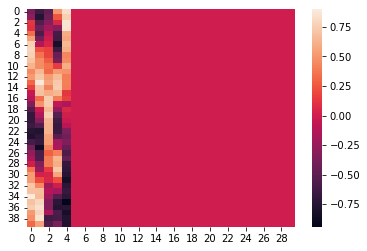

In [15]:
import seaborn as sns
sns.heatmap(coef_multi_task_lasso_)

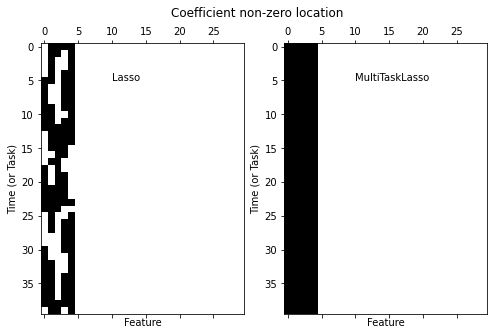

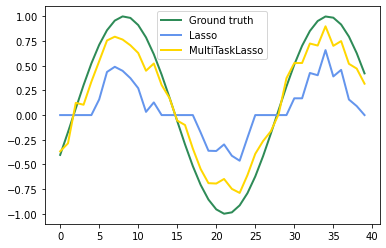

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.spy(coef_lasso_)
plt.xlabel("Feature")
plt.ylabel("Time (or Task)")
plt.text(10, 5, "Lasso")
plt.subplot(1, 2, 2)
plt.spy(coef_multi_task_lasso_)
plt.xlabel("Feature")
plt.ylabel("Time (or Task)")
plt.text(10, 5, "MultiTaskLasso")
fig.suptitle("Coefficient non-zero location")

feature_to_plot = 0
plt.figure()
lw = 2
plt.plot(coef[:, feature_to_plot], color="seagreen", linewidth=lw, label="Ground truth")
plt.plot(
    coef_lasso_[:, feature_to_plot], color="cornflowerblue", linewidth=lw, label="Lasso"
)
plt.plot(
    coef_multi_task_lasso_[:, feature_to_plot],
    color="gold",
    linewidth=lw,
    label="MultiTaskLasso",
)
plt.legend(loc="upper center")
plt.axis("tight")
plt.ylim([-1.1, 1.1])
plt.show()

In [22]:
mtl =  MultiTaskLasso(alpha=1.0)
??mtl.fit